<a href="https://colab.research.google.com/github/vardhini20/portal/blob/main/Point_cloud_classification_by_using_point_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point Cloud Classification by using Point Net

I/P: Point Cloud <br/>
O/P: Classify this input

In [ ]:
pip install trimesh

     |████████████████████████████████| 642 kB 5.2 MB/s 


# Import Libraries

In [ ]:
import tensorflow as tf # Google Deep Learning Library (Neural Net)
from tensorflow import keras # keras is a framework
from tensorflow.keras import layers # accessing the layers of neural net
import os # to access the file manager
import trimesh # display 3d data of objects
import matplotlib.pyplot as plt # plot the graph
import glob
import numpy as np

# Load the dataset

In [ ]:
url='http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip'

src=tf.keras.utils.get_file("data.zip",url,extract=True)

473415680/473402300 [==============================] - 5s 0us/step


In [ ]:
src=os.path.join(os.path.dirname(src),"ModelNet10")

In [ ]:
mesh=trimesh.load(os.path.join(src,"chair/train/chair_0001.off"))
mesh.show()

# Visualise the point cloud for this object

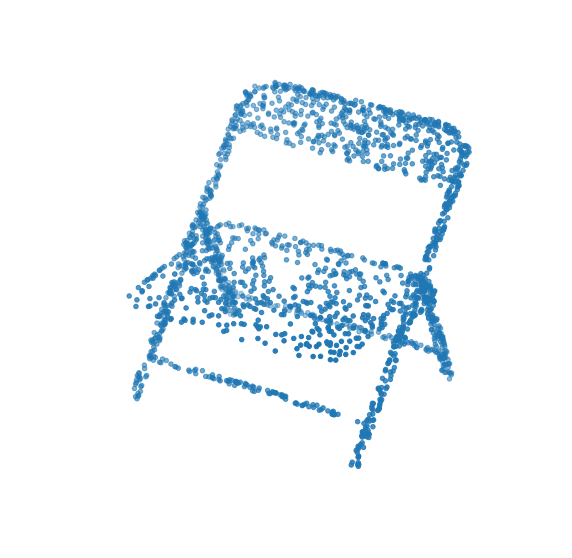

In [ ]:
# create points
points=mesh.sample(2048)

fig=plt.figure(figsize=(10,10)) # creating a figure
ax=fig.add_subplot(111,projection='3d') # creating 3d projection
ax.scatter(points[:,0],points[:,1],points[:,2]) # x-axis,y-axis,z-axis
ax.set_axis_off()
plt.show()

# Pre-Processing on this dataset

In [ ]:
def preprocess_data(num_points=2048):

  train_points=[] # splitting the dataset into train and test (X)
  train_labels=[] # output - category, class(Y)

  test_points=[] # list is different from dict
  test_labels=[]

  map_class={} # class map (dict)

  folders=glob.glob(os.path.join(src,"[!README]*"))

  for i,folder in enumerate(folders):
    print("processing class: {}".format(os.path.basename(folder)))
    # store the folder name with ID
    map_class[i]=folder.split('/')[-1] # chair, desk, mointor

    # collect all the files
    train_files=glob.glob(os.path.join(folder,"train/*")) # collecting from train folder
    test_files=glob.glob(os.path.join(folder,"test/*")) # collecting from test folder

    for j in train_files:
      dummy=trimesh.load(j).sample(num_points) # loading the 3d points
      train_points.append(dummy)
      train_labels.append(i)

    for j in test_files:
      dummy=trimesh.load(j).sample(num_points)
      test_points.append(dummy)
      test_labels.append(i)

  return(np.array(train_points),np.array(test_points),np.array(train_labels),np.array(test_labels),map_class)



In [ ]:
# define the parameters for pre-processing the data
num_points=2048
num_classes=10
batch_size=32 # 32 files at one stretch

train_points,test_points,train_labels,test_labels,map_class=preprocess_data(num_points)

processing class: chair
processing class: bathtub
processing class: table
processing class: sofa
processing class: toilet
processing class: monitor
processing class: dresser
processing class: desk
processing class: night_stand
processing class: bed


# Data Augmentation

Increasing your data size

In [ ]:
def data_augmentation(points,label):

  # randomly shuffled points
  # random points in the range of -0.005 to 0.005
  points+=tf.random.uniform(points.shape, -0.005,0.005,dtype=tf.float64)
  # shuffle points
  points=tf.random.shuffle(points)
  return points,label

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_points,train_labels))
test_dataset=tf.data.Dataset.from_tensor_slices((test_points,test_labels))

In [ ]:
train_dataset=train_dataset.shuffle(len(train_points)).map(data_augmentation).batch(batch_size)
test_dataset=test_dataset.shuffle(len(test_points)).batch(batch_size)

# Build the logical model

In [ ]:
def conv(x,filters): # defined a convolution layer
  x=layers.Conv1D(filters,kernel_size=1,padding="valid")(x)
  x=layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation("relu")(x)

In [ ]:
def dense(x,filters): # defined dense layer
  x=layers.Dense(filters)(x)
  x=layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation("relu")(x)

# PointNet - MLP + Transformation Net

In [ ]:
class MLP(keras.regularizers.Regularizer):
  def __init__(self,num_features,l2reg=0.001):
    self.num_features=num_features
    self.l2reg=l2reg
    self.eye=tf.eye(num_features)

  def __call__(self,x):
    x=tf.reshape(x, (-1,self.num_features,self.num_features))
    xxt=tf.tensordot(x,x,axes=(2,2))
    xxt=tf.reshape(xxt, (-1,self.num_features,self.num_features))
    return tf.reduce_sum(self.l2reg *tf.square(xxt-self.eye))


In [ ]:
def tnet(inputs,num_features):

  bias=keras.initializers.Constant(np.eye(num_features).flatten())
  mlp=MLP(num_features)

  x=conv(inputs,32)
  x=conv(x,64)
  x=conv(x,512)
  x=layers.GlobalMaxPool1D()(x)
  x=dense(x,256)
  x=dense(x,128)
  x=layers.Dense(num_features*num_features,kernel_initializer='zeros',bias_initializer=bias,activity_regularizer=mlp)(x)
  a=layers.Reshape((num_features,num_features))(x)
  return layers.Dot(axes=(2,1))([inputs,a])

# Model Training

In [ ]:
inputs=keras.Input(shape=(num_points,3))

x=tnet(inputs,3)
x=conv(x,32)
x=conv(x,32)
x=tnet(x,32)
x=conv(x,32)
x=conv(x,64)
x=conv(x,512)
x=layers.GlobalMaxPool1D()(x)
x=dense(x,256)
x=layers.Dropout(0.3)(x)
x=dense(x,128)
x=layers.Dropout(0.3)(x)

outputs=layers.Dense(num_classes,activation='softmax')(x)

model=keras.Model(inputs=inputs,outputs=outputs,name='pointNet')

In [ ]:
model.summary()

Model: "pointNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 2048, 32)     128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 2048, 32)    128         ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 2048, 32)     0           ['batch_normalization_5[0]

# Training Model

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['sparse_categorical_accuracy'])

model.fit(train_dataset,epochs=20,validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 490s 4s/step - loss: 3.4588 - sparse_categorical_accuracy: 0.2934 - val_loss: 33753.6094 - val_sparse_categorical_accuracy: 0.1652
Epoch 2/20
125/125 [==============================] - 488s 4s/step - loss: 3.0307 - sparse_categorical_accuracy: 0.3741 - val_loss: 99533747501259554816.0000 - val_sparse_categorical_accuracy: 0.3139
Epoch 3/20
125/125 [==============================] - 494s 4s/step - loss: 2.8009 - sparse_categorical_accuracy: 0.4362 - val_loss: 13928161255358464.0000 - val_sparse_categorical_accuracy: 0.4350
Epoch 4/20
125/125 [==============================] - 496s 4s/step - loss: 2.6716 - sparse_categorical_accuracy: 0.4971 - val_loss: 109090139275264.0000 - val_sparse_categorical_accuracy: 0.4692
Epoch 5/20
125/125 [==============================] - 503s 4s/step - loss: 2.5143 - sparse_categorical_accuracy: 0.5555 - val_loss: 15047472447488.0000 - val_sparse_categorical_accuracy: 0.5782
Epoch 6/20
125/125 [=========

# Test the PointNet

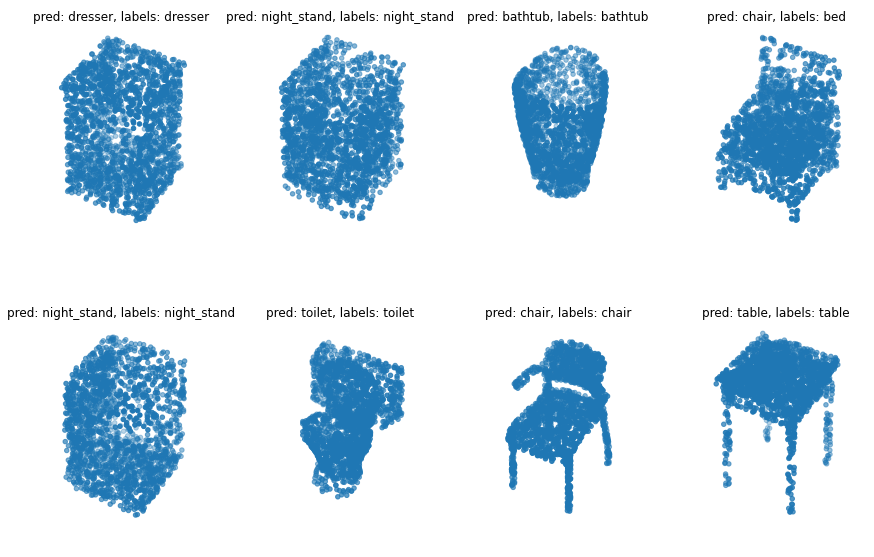

In [ ]:
data=test_dataset.take(1)

points,labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

preds=model.predict(points) #points to the pointnet
preds=tf.math.argmax(preds,-1)

points = points.numpy()

fig= plt.figure(figsize=(15,10))
for i in range(8):
  ax=fig.add_subplot(2,4,i+1,projection="3d")
  ax.scatter(points[i,:,0],points[i, :, 1],points[i,:,2])
  ax.set_title("pred: {:}, labels: {:}".format(map_class[preds[i].numpy()],map_class[labels.numpy()[i]]))
  ax.set_axis_off()
plt.show()